<a href="https://colab.research.google.com/github/laufragor/filtro-commenti-tossici/blob/main/toxic_comment_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Toxic Comment Filter**

Costruire un modello in grado di filtrare i commenti degli utenti in base al grado di dannosità del linguaggio:
1. Preprocessare il testo eliminando l'insieme di token che non danno contributo significativo a livello semantico
2. Trasformare il corpus testuale in sequenze
3. Costruire un modello di Deep Learning comprendente dei layer ricorrenti per un task di classificazione multilabel
4. In prediction time, il modello deve ritornare un vettore contenente un 1 o uno 0 in corrispondenza di ogni label presente nel dataset (toxic,	severe_toxic,	obscene,	threat,	insult,	identity_hate). In questo modo, un commento non dannoso sarà classificato da un vettore di soli 0 [0,0,0,0,0,0]. Al contrario, un commento pericoloso presenterà almeno un 1 tra le 6 labels.

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, multilabel_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import make_pipeline
from keras.models import Sequential, Model
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, LSTM, Dense, Bidirectional, TimeDistributed, Dropout
from keras.utils import pad_sequences
from keras.backend import clear_session
from keras.callbacks import EarlyStopping
from keras.metrics import Precision, Recall, F1Score
from keras.regularizers import l2

import pickle
import string
import re
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Iperparametri
NUM_WORDS = 10000

In [ ]:
BASE_URL = "https://s3.eu-west-3.amazonaws.com/profession.ai/datasets/"
df = pd.read_csv(BASE_URL+"Filter_Toxic_Comments_dataset.csv")
df.head(10)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0
5,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,4
7,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,0
8,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,0
9,alignment on this subject and which are contra...,0,0,0,0,0,0,0


# ***ANALISI ESPLORATIVA***

## Controllo dimensione del dataset e tipi delle variabili

In [ ]:
print("Il dataset ha {} commenti".format(len(df)))

Il dataset ha 159571 commenti


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comment_text   159571 non-null  object
 1   toxic          159571 non-null  int64 
 2   severe_toxic   159571 non-null  int64 
 3   obscene        159571 non-null  int64 
 4   threat         159571 non-null  int64 
 5   insult         159571 non-null  int64 
 6   identity_hate  159571 non-null  int64 
 7   sum_injurious  159571 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 9.7+ MB


## Controllo valori mancanti e duplicati

In [ ]:
n_missing = df.isna().sum().sum()
n_missing

0

In [ ]:
n_duplicates = df.duplicated().sum()
n_duplicates

0

## Controllo la distribuzione dei commenti puliti e dannosi

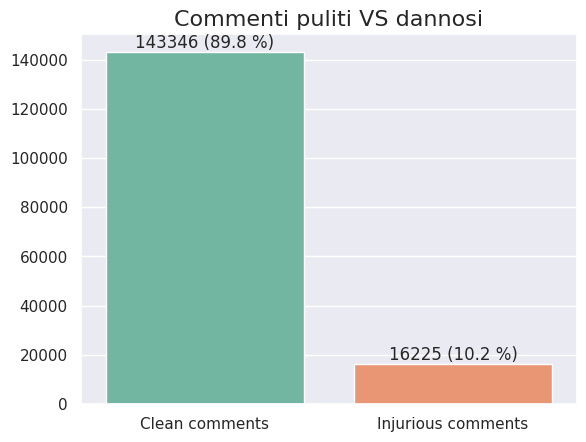

In [ ]:
cnt_clean_injurious = [len(df[df["sum_injurious"] == 0]), len(df[df["sum_injurious"] != 0])]

sns.barplot(x=["Clean comments", "Injurious comments"], y=cnt_clean_injurious, palette="Set2")
plt.title("Commenti puliti VS dannosi", fontsize=16)
for i, val in enumerate(cnt_clean_injurious):
    plt.text(i, val,
             str(val) + " ({:.1f} %)".format(val / len(df) * 100),
             ha="center", va="bottom")

Il dataset è sbilanciato, circa il 90% dei commenti sono puliti. Ora vediamo se c'è sbilanciamento anche tra le singole label:

## Distribuzione dei commenti per categoria

In [ ]:
labels_names = df.columns[1: -1]

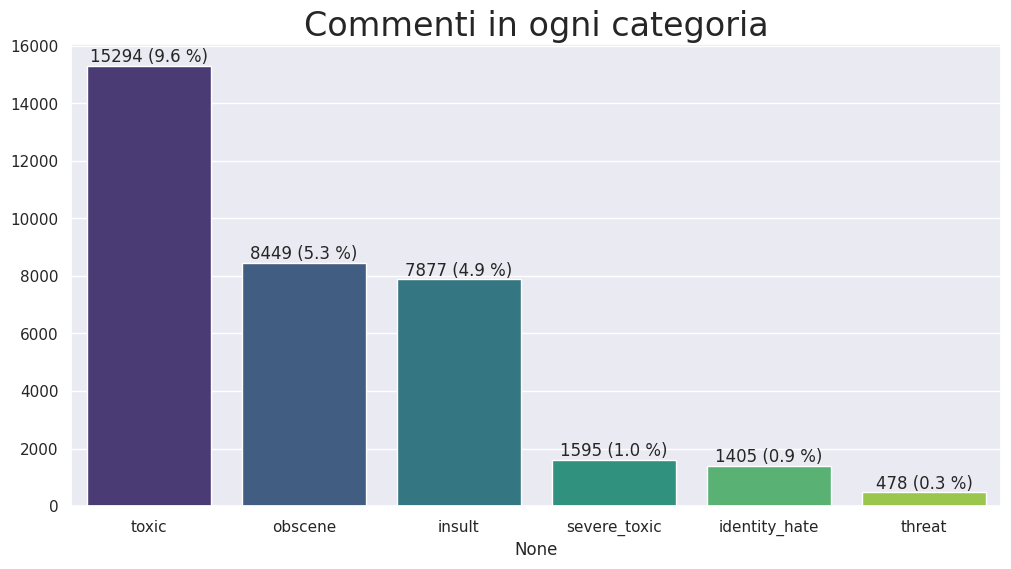

In [ ]:
labels_occurrences_sorted = df[labels_names].sum().sort_values(ascending=False).values
labels_names_sorted = df[labels_names].sum().sort_values(ascending=False).index

plt.figure(figsize=(12, 6))
sns.barplot(x=labels_names_sorted, y=labels_occurrences_sorted,
            palette="viridis")
plt.title("Commenti in ogni categoria", fontsize=24)
for i, val in enumerate(labels_occurrences_sorted):
    plt.text(i, val,
             str(val) + " ({:.1f} %)".format(val / len(df) * 100),
             ha="center", va="bottom")

Notiamo che le label non sono distribuite allo stesso modo; ad esempio, i commenti etichettati come *toxic* sono oltre 30 volte tanto quelli etichettati come *threat*. Sarà opportuno definire dei pesi relativi alle singole etichette in base alla loro frequenza nel dataset.

# ***TEXT PREPROCESSING***

Prepariamo il testo per darlo in pasto al modello.

In [ ]:
english_stopwords = stopwords.words("english")

def preprocess_text(text):

    # lowercase
    text = text.lower()
    # remove punctuation
    for c in string.punctuation:
      text = text.replace(c, " ")
    # remove digits
    text = re.sub('\d', '', text)
    # remove common english words
    text = " ".join([word for word in text.split() if len(word) > 1 and word not in english_stopwords])
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text)

    return text

In [ ]:
sampletext = '68.191.214.247  }}, \n\nI have not made any personal attacks whatsoever. This ban is completely unwarranted and is in the form **of persecution, because I drew attention to the personal attacks made by another user. Clearly, certain users are blatantly abusing their authority.'
preprocess_text(sampletext)

'made personal attacks whatsoever ban completely unwarranted form persecution drew attention personal attacks made another user clearly certain users blatantly abusing authority'

In [ ]:
# Puliamo tutti i commenti
df["comment_text"] = df["comment_text"].apply(preprocess_text)

# ***DATASET E PESI DELLE CLASSI***



In [ ]:
X = df["comment_text"].values
Y = df[labels_names].values

In [ ]:
labels_relative_frequencies = df[labels_names].sum() / len(df)

# weights based on inverse relative frequencies
class_weights = {i: val for i, val in enumerate(1 / labels_relative_frequencies)}
class_weights

{0: 10.433568719759382,
 1: 100.04451410658307,
 2: 18.886377086045687,
 3: 333.8305439330544,
 4: 20.257839278913295,
 5: 113.57366548042704}

# ***REGRESSIONE LOGISTICA***
Addestro un modello naive di regressione logistica per avere delle metriche baseline. Per gestire la classificazione multilabel, uso un `MultiOutputClassifier` di sklearn.

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [ ]:
multi_logreg_pipeline = make_pipeline(
    CountVectorizer(stop_words="english", max_features=NUM_WORDS),
    MultiOutputClassifier(LogisticRegression(class_weight=class_weights))    # uso i pesi definiti in precedenza
)

In [ ]:
multi_logreg_pipeline.fit(X_train, Y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=10000, stop_words='english')),
                ('multioutputclassifier',
                 MultiOutputClassifier(estimator=LogisticRegression(class_weight={0: 10.433568719759382,
                                                                                  1: 100.04451410658307,
                                                                                  2: 18.886377086045687,
                                                                                  3: 333.8305439330544,
                                                                                  4: 20.257839278913295,
                                                                                  5: 113.57366548042704})))])

## Risultati

In [ ]:
Y_pred_test_logreg = multi_logreg_pipeline.predict(X_test)
print(classification_report(Y_test, Y_pred_test_logreg, target_names=labels_names))

               precision    recall  f1-score   support

        toxic       0.60      0.83      0.69      3101
 severe_toxic       0.35      0.58      0.44       329
      obscene       0.67      0.83      0.74      1698
       threat       0.31      0.51      0.39        91
       insult       0.50      0.76      0.60      1594
identity_hate       0.30      0.45      0.36       298

    micro avg       0.56      0.78      0.65      7111
    macro avg       0.45      0.66      0.54      7111
 weighted avg       0.56      0.78      0.65      7111
  samples avg       0.07      0.08      0.07      7111



Visto che il dataset è sbilanciato, invece che l'*accuracy* è opportuno usare metriche come *Precision* e *Recall*: il *F1 Score* è un'ottima metrica che tiene conto di entrambe, monitoreremo perciò questa.  <br><br>
Notiamo che le label meno rappresentate (*severe_toxic*, *threat* e *identity_hate*) hanno metriche inferiori rispetto alle altre.  
Nel complesso, con il modello naive otteniamo F1 score pesato di circa 0.65.

# ***TOKENIZER***

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [ ]:
tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(X_train)

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

Median length: 16.0
95th percentile length: 104.0


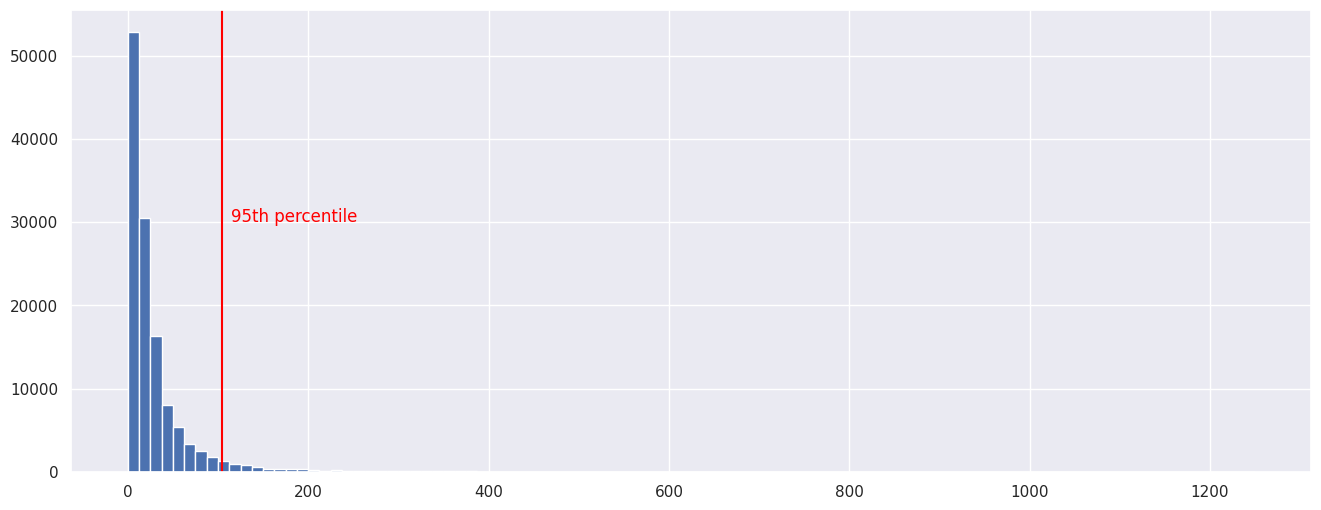

In [ ]:
# Choosing maxlen based on 95th percentile length
train_seq_lens = [len(x) for x in train_sequences]
print("Median length:", np.percentile(train_seq_lens, 50))
percentile_95 = np.percentile(train_seq_lens, 95)
print("95th percentile length:", percentile_95)

plt.figure(figsize=(16, 6))
plt.hist(train_seq_lens, bins=100)
plt.axvline(percentile_95, c="red")
plt.text(percentile_95 + 10, 30000, "95th percentile", c="red")

maxlen = 100    # ~~ 95th percentile

In [ ]:
padded_train_sequences = pad_sequences(train_sequences, maxlen=maxlen)
padded_test_sequences = pad_sequences(test_sequences, maxlen=maxlen)

# ***MODELLO 1***

In [ ]:
clear_session()
model = Sequential([
    Embedding(input_dim=NUM_WORDS, output_dim=64, input_length=maxlen),
    Bidirectional(LSTM(32, activation="tanh")),
    Dense(16, activation="relu"),
    Dense(6, activation="sigmoid")
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           640000    
                                                                 
 bidirectional (Bidirection  (None, 64)                24832     
 al)                                                             
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 6)                 102       
                                                                 
Total params: 665974 (2.54 MB)
Trainable params: 665974 (2.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
METRICS = [
    F1Score(name='f1_score',
            average='weighted', # use weighted average to account for labels imbalance
            threshold=0.5),
]
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=METRICS)

In [ ]:
history = model.fit(padded_train_sequences, Y_train.astype("float32"), epochs=15,
                    validation_split=0.1,
                    class_weight=class_weights)

Epoch 1/15
3591/3591 [==============================] - 103s 27ms/step - loss: 0.8932 - f1_score: 0.5722 - val_loss: 0.0539 - val_f1_score: 0.6739
Epoch 2/15
3591/3591 [==============================] - 55s 15ms/step - loss: 0.6105 - f1_score: 0.6970 - val_loss: 0.0510 - val_f1_score: 0.7007
Epoch 3/15
3591/3591 [==============================] - 53s 15ms/step - loss: 0.5265 - f1_score: 0.7314 - val_loss: 0.0534 - val_f1_score: 0.7027
Epoch 4/15
3591/3591 [==============================] - 52s 14ms/step - loss: 0.4552 - f1_score: 0.7720 - val_loss: 0.0554 - val_f1_score: 0.7053
Epoch 5/15
3591/3591 [==============================] - 51s 14ms/step - loss: 0.3895 - f1_score: 0.8023 - val_loss: 0.0576 - val_f1_score: 0.7162
Epoch 6/15
3591/3591 [==============================] - 50s 14ms/step - loss: 0.3279 - f1_score: 0.8363 - val_loss: 0.0630 - val_f1_score: 0.7143
Epoch 7/15
3591/3591 [==============================] - 52s 14ms/step - loss: 0.2805 - f1_score: 0.8633 - val_loss: 0.0690 

In [ ]:
# Creazione dei subplot
def plot_loss_and_f1_score(history_df):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))

  # Plot per la loss
  history_df[['loss', 'val_loss']].plot(ax=ax1)
  ax1.set_title('Loss (Training e Validation)')
  ax1.set_xlabel('Epoche')
  ax1.set_ylabel('Loss')

  # Plot per l'F1 score
  history_df[['f1_score', 'val_f1_score']].plot(ax=ax2)
  ax2.set_title('F1 Score (Training e Validation)')
  ax2.set_xlabel('Epoche')
  ax2.set_ylabel('F1 Score')

  plt.tight_layout()
  plt.show()

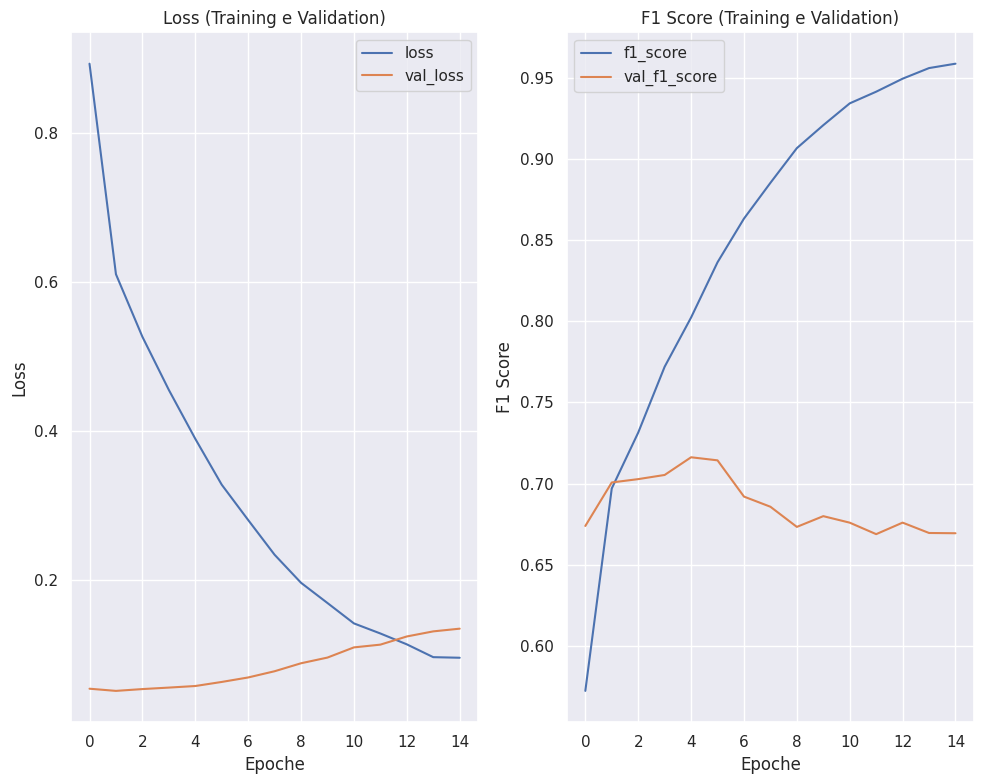

In [ ]:
history_df = pd.DataFrame(history.history)
plot_loss_and_f1_score(history_df)

### Metriche sul train set

In [ ]:
Y_pred_train = model.predict(padded_train_sequences).round()
print(classification_report(Y_train, Y_pred_train, target_names=labels_names))

3990/3990 [==============================] - 23s 5ms/step
               precision    recall  f1-score   support

        toxic       0.97      0.95      0.96     12193
 severe_toxic       0.85      0.80      0.82      1266
      obscene       0.96      0.96      0.96      6751
       threat       0.88      0.86      0.87       387
       insult       0.95      0.93      0.94      6283
identity_hate       0.91      0.87      0.89      1107

    micro avg       0.95      0.93      0.94     27987
    macro avg       0.92      0.89      0.91     27987
 weighted avg       0.95      0.93      0.94     27987
  samples avg       0.09      0.09      0.09     27987



### Metriche sul test set

In [ ]:
Y_pred_test = model.predict(padded_test_sequences).round()
print(classification_report(Y_test, Y_pred_test, target_names=labels_names))

998/998 [==============================] - 6s 5ms/step
               precision    recall  f1-score   support

        toxic       0.73      0.71      0.72      3101
 severe_toxic       0.38      0.33      0.35       329
      obscene       0.77      0.74      0.76      1698
       threat       0.26      0.19      0.22        91
       insult       0.66      0.60      0.63      1594
identity_hate       0.44      0.37      0.40       298

    micro avg       0.70      0.65      0.68      7111
    macro avg       0.54      0.49      0.51      7111
 weighted avg       0.69      0.65      0.67      7111
  samples avg       0.06      0.06      0.06      7111



### Matrici di confusione per il test set

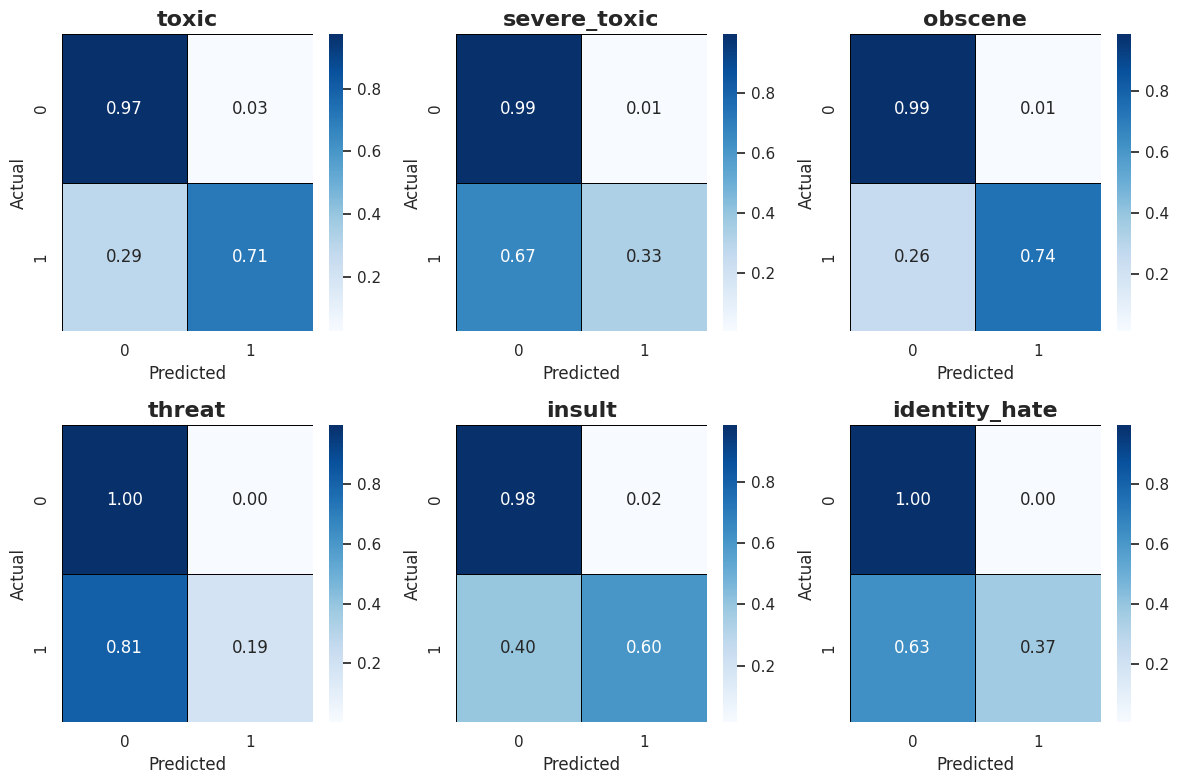

In [ ]:
mcms = multilabel_confusion_matrix(Y_test, Y_pred_test)
mcms_norm = [normalize(mcm, axis=1, norm="l1") for mcm in mcms]

plt.figure(figsize=(12, 8))
for i, lbl in enumerate(labels_names):
  plt.subplot(2, 3, i + 1)
  sns.heatmap(mcms_norm[i], annot=True, cmap="Blues", fmt=".2f",
              linewidths=0.5, linecolor="black")
  plt.title(lbl, fontsize=16, fontweight="bold")
  plt.xlabel("Predicted")
  plt.ylabel("Actual")

plt.tight_layout()

Siamo di fronte ad overfitting in quanto all'aumentare del numero di epoche le prestazioni sul train set migliorano decisamente, ma quelle sul test set restano simili o peggiorano. Dopo 15 epoche abbiamo prestazioni di pochissimo superiori ad una regressione logistica (qua abbiamo 0.67 di F1 score pesato)

 Provo ad affrontare l'overfitting usando regolarizzazione e dropout.

# ***2°MODELLO: REGOLARIZZAZIONE L2***

In [ ]:
clear_session()
model2 = Sequential([
    Embedding(input_dim=NUM_WORDS, output_dim=64, input_length=maxlen),
    Bidirectional(LSTM(32, activation="tanh", kernel_regularizer=l2(0.01))),
    Dense(16, activation="relu"),
    Dense(6, activation="sigmoid")
])
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           640000    
                                                                 
 bidirectional (Bidirection  (None, 64)                24832     
 al)                                                             
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 6)                 102       
                                                                 
Total params: 665974 (2.54 MB)
Trainable params: 665974 (2.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model2.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=METRICS)

In [ ]:
history2 = model2.fit(padded_train_sequences, Y_train.astype("float32"), epochs=15,
                     validation_split=0.1,
                     class_weight=class_weights)

Epoch 1/15
3591/3591 [==============================] - 93s 25ms/step - loss: 1.0900 - f1_score: 0.5298 - val_loss: 0.0771 - val_f1_score: 0.6688
Epoch 2/15
3591/3591 [==============================] - 48s 13ms/step - loss: 0.7072 - f1_score: 0.6739 - val_loss: 0.0690 - val_f1_score: 0.6876
Epoch 3/15
3591/3591 [==============================] - 47s 13ms/step - loss: 0.6568 - f1_score: 0.6889 - val_loss: 0.0733 - val_f1_score: 0.6522
Epoch 4/15
3591/3591 [==============================] - 47s 13ms/step - loss: 0.6209 - f1_score: 0.7033 - val_loss: 0.0684 - val_f1_score: 0.6822
Epoch 5/15
3591/3591 [==============================] - 45s 13ms/step - loss: 0.6045 - f1_score: 0.7101 - val_loss: 0.0685 - val_f1_score: 0.7042
Epoch 6/15
3591/3591 [==============================] - 46s 13ms/step - loss: 0.5771 - f1_score: 0.7160 - val_loss: 0.0712 - val_f1_score: 0.6991
Epoch 7/15
3591/3591 [==============================] - 45s 13ms/step - loss: 0.5588 - f1_score: 0.7252 - val_loss: 0.0749 -

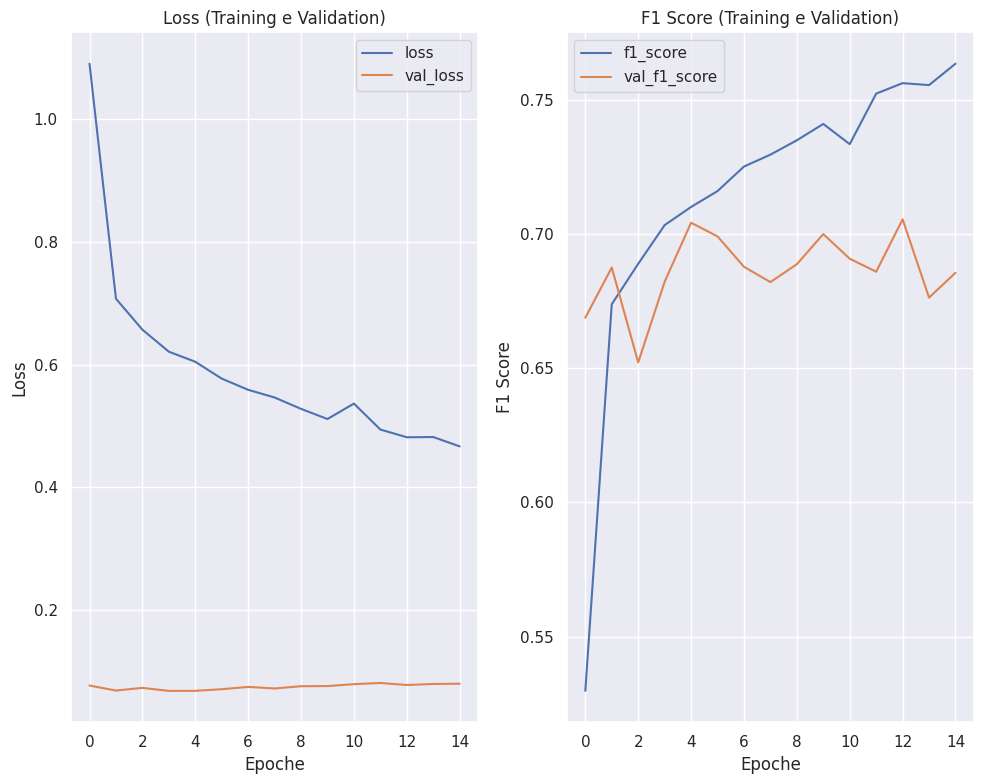

In [ ]:
history2_df = pd.DataFrame(history2.history)
plot_loss_and_f1_score(history2_df)

### Risultati sul train set

In [ ]:
Y_pred_train = model2.predict(padded_train_sequences).round()
print(classification_report(Y_train, Y_pred_train, target_names=labels_names))

3990/3990 [==============================] - 19s 5ms/step
               precision    recall  f1-score   support

        toxic       0.93      0.73      0.82     12193
 severe_toxic       0.64      0.28      0.39      1266
      obscene       0.87      0.83      0.85      6751
       threat       0.22      0.24      0.23       387
       insult       0.76      0.78      0.77      6283
identity_hate       0.59      0.15      0.24      1107

    micro avg       0.85      0.71      0.77     27987
    macro avg       0.67      0.50      0.55     27987
 weighted avg       0.84      0.71      0.76     27987
  samples avg       0.06      0.06      0.06     27987



### Risultati sul test set

In [ ]:
Y_pred_test = model2.predict(padded_test_sequences).round()
print(classification_report(Y_test, Y_pred_test, target_names=labels_names))

998/998 [==============================] - 5s 5ms/step
               precision    recall  f1-score   support

        toxic       0.88      0.65      0.75      3101
 severe_toxic       0.64      0.24      0.35       329
      obscene       0.81      0.77      0.79      1698
       threat       0.06      0.10      0.08        91
       insult       0.70      0.68      0.69      1594
identity_hate       0.43      0.09      0.15       298

    micro avg       0.78      0.64      0.70      7111
    macro avg       0.59      0.42      0.47      7111
 weighted avg       0.78      0.64      0.69      7111
  samples avg       0.06      0.06      0.05      7111



Nonostante l'utilizzo di una tecnica di regolarizzazione (L2), osserviamo che le prestazioni sul set di test rimangono praticamente inalterate, e come nello scorso caso, per il set di test la loss peggiora avanzando con le epoche e il F1 score non migliora. Rimane overfitting. Proviamo con il dropout.

# ***3°MODELLO: DROPOUT***

In [ ]:
clear_session()
model3 = Sequential([
    Embedding(input_dim=NUM_WORDS, output_dim=64, input_length=maxlen),
    Dropout(0.2),
    Bidirectional(LSTM(32, activation="tanh")),
    Dropout(0.2),
    Dense(16, activation="relu"),
    Dropout(0.2),
    Dense(6, activation="sigmoid")
])
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           640000    
                                                                 
 dropout (Dropout)           (None, 100, 64)           0         
                                                                 
 bidirectional (Bidirection  (None, 64)                24832     
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                        

In [ ]:
model3.compile(optimizer="adam",
               loss="binary_crossentropy",
               metrics=METRICS)

In [ ]:
history3 = model3.fit(padded_train_sequences, Y_train.astype("float32"), epochs=15,
                      validation_split=0.1,
                      class_weight=class_weights)

Epoch 1/15
3591/3591 [==============================] - 92s 24ms/step - loss: 0.9343 - f1_score: 0.5971 - val_loss: 0.0528 - val_f1_score: 0.6762
Epoch 2/15
3591/3591 [==============================] - 49s 14ms/step - loss: 0.6637 - f1_score: 0.6713 - val_loss: 0.0536 - val_f1_score: 0.6661
Epoch 3/15
3591/3591 [==============================] - 48s 13ms/step - loss: 0.6037 - f1_score: 0.6858 - val_loss: 0.0524 - val_f1_score: 0.6716
Epoch 4/15
3591/3591 [==============================] - 47s 13ms/step - loss: 0.5484 - f1_score: 0.7017 - val_loss: 0.0553 - val_f1_score: 0.6785
Epoch 5/15
3591/3591 [==============================] - 46s 13ms/step - loss: 0.5055 - f1_score: 0.7194 - val_loss: 0.0554 - val_f1_score: 0.6786
Epoch 6/15
3591/3591 [==============================] - 46s 13ms/step - loss: 0.4790 - f1_score: 0.7318 - val_loss: 0.0582 - val_f1_score: 0.6841
Epoch 7/15
3591/3591 [==============================] - 45s 12ms/step - loss: 0.4524 - f1_score: 0.7455 - val_loss: 0.0642 -

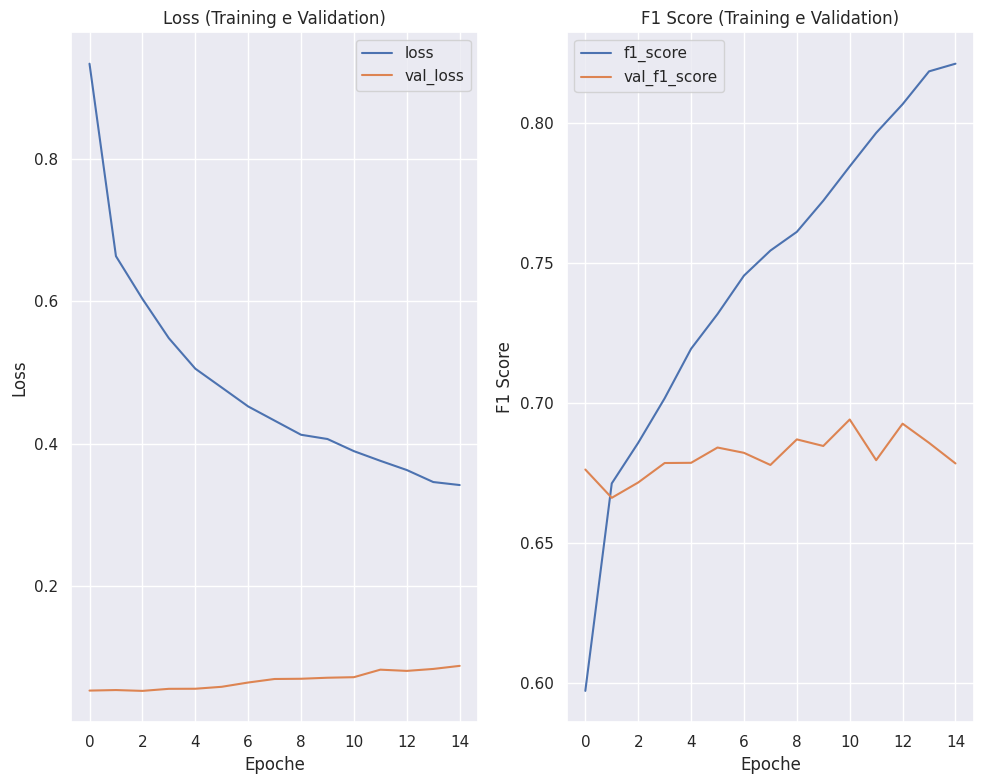

In [ ]:
history3_df = pd.DataFrame(history3.history)
plot_loss_and_f1_score(history3_df)

### Risultati sul train set

In [ ]:
Y_pred_train = model3.predict(padded_train_sequences).round()
print(classification_report(Y_train, Y_pred_train, target_names=labels_names))

3990/3990 [==============================] - 20s 5ms/step
               precision    recall  f1-score   support

        toxic       0.89      0.92      0.91     12193
 severe_toxic       0.75      0.18      0.29      1266
      obscene       0.93      0.89      0.91      6751
       threat       0.69      0.10      0.18       387
       insult       0.84      0.85      0.85      6283
identity_hate       0.76      0.36      0.48      1107

    micro avg       0.89      0.83      0.86     27987
    macro avg       0.81      0.55      0.60     27987
 weighted avg       0.88      0.83      0.84     27987
  samples avg       0.09      0.08      0.08     27987



### Risultati sul test set

In [ ]:
Y_pred_test = model3.predict(padded_test_sequences).round()
print(classification_report(Y_test, Y_pred_test, target_names=labels_names))

998/998 [==============================] - 5s 4ms/step
               precision    recall  f1-score   support

        toxic       0.75      0.76      0.75      3101
 severe_toxic       0.52      0.09      0.16       329
      obscene       0.82      0.76      0.79      1698
       threat       0.14      0.01      0.02        91
       insult       0.69      0.66      0.67      1594
identity_hate       0.48      0.18      0.27       298

    micro avg       0.75      0.67      0.71      7111
    macro avg       0.57      0.41      0.44      7111
 weighted avg       0.72      0.67      0.69      7111
  samples avg       0.07      0.06      0.06      7111



Anche in questo caso, nonostante l'uso di una tecnica di regolarizzazione (il dropout) l'overfitting rimane, e le prestazioni sono molto simili ai due casi precedenti. Si può anche vedere dai grafici della history.

### Conclusioni
